In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

#import ncar_jobqueue
#from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from scipy import stats
#import pop_tools 
#import pandas as pd
import cftime
#import matplotlib.colors as colors
#import utils

### Read in ERA SST data

In [2]:
path = '/glade/derecho/scratch/gseijo/era5/SST_1980_2024/sst'

ds = xr.open_dataset(path + '/sst_1995_daily.nc')

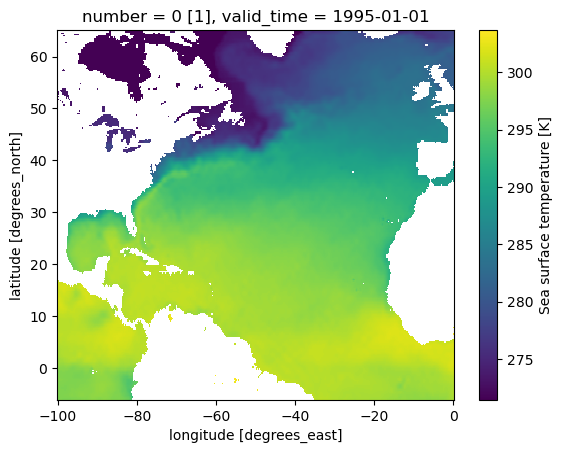

In [3]:
ds.sst.isel(valid_time=0).plot()

In [4]:
#An example for 1/12 degree:

area = xr.DataArray(np.zeros([285,401]), dims=('latitude','longitude'))

j=0

for lat in ds.latitude.values:

    #print(lat)

    pi     =    3.14159265359
    radius = 6378.137
    
    deg2rad = pi / 180.0
    
    resolution_lat =1./4. #res in degrees
    resolution_lon =1./4. #res in degrees
    
    elevation = deg2rad * (lat + (resolution_lat / 2.0))
    
    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat
    
    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))

    j = j + 1

#ds_sat['area']=area

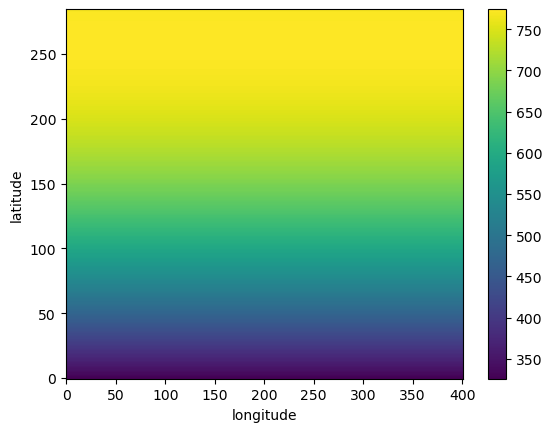

In [5]:
area.plot()

In [6]:
ones = np.full((285,401),1,dtype=int)
ones = xr.DataArray(ones,dims=('latitude','longitude'))

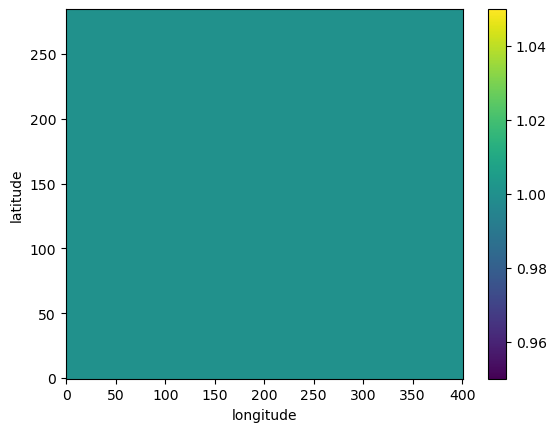

In [7]:
ones.plot()

In [8]:
#--- define region boxes:
#--- northern PR
NPR_lon_min = -69
NPR_lon_max = -64
NPR_lat_min = 18.25
NPR_lat_max = 21.5
 
#--- southern PR
SPR_lon_min = -69
SPR_lon_max = -64
SPR_lat_min = 15
SPR_lat_max = 18.25

In [9]:
lats = ds.latitude
lons = ds.longitude

In [10]:
mask_NPR = ones.where(lats<NPR_lat_max).where(lats>NPR_lat_min).where(lons<NPR_lon_max).where(lons>NPR_lon_min)
mask_NPR = mask_NPR.where(ds.sst.isel(valid_time=0) > -10)

mask_SPR = ones.where(lats<SPR_lat_max).where(lats>SPR_lat_min).where(lons<SPR_lon_max).where(lons>SPR_lon_min)
mask_SPR = mask_SPR.where(ds.sst.isel(valid_time=0) > -10)

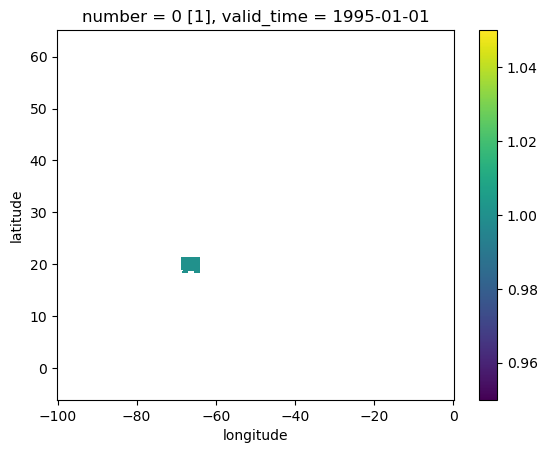

In [11]:
mask_NPR.plot()

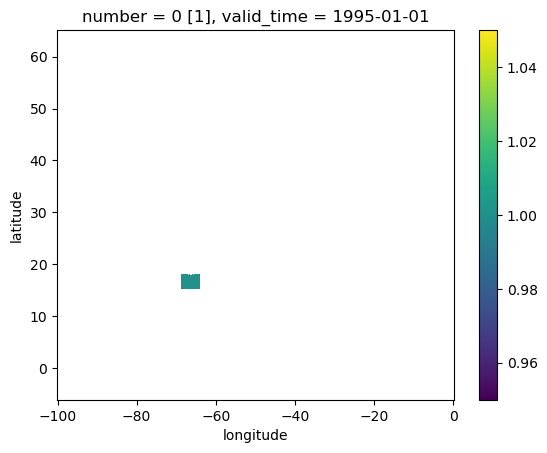

In [12]:
mask_SPR.plot()

In [15]:
#test masking and area averaging
var='sst'
masked_var = ds[var].where(mask_NPR==1)
masked_area = area.where(mask_NPR==1)
weighted_mean_var = (masked_var * masked_area).sum(dim=('longitude','latitude')) / masked_area.sum(dim=('longitude','latitude'))
weighted_mean_var = weighted_mean_var - 273.15

In [16]:
weighted_mean_var.attrs['units'] = 'deg C'

In [17]:
tlen_sum = 0

for year in np.arange(1980,2025,1):

    ds = xr.open_dataset(path + '/sst_' + str(year) + '_daily.nc')

    tlen = len(ds.valid_time)

    tlen_sum = tlen_sum + tlen
    
tlen_sum

16437

In [18]:
path = '/glade/derecho/scratch/gseijo/era5/SST_1980_2024/sst'
spr_ts = np.empty(tlen_sum)
npr_ts = np.empty(tlen_sum)
times = np.empty(tlen_sum)
i = 0

for year in np.arange(1980,2025,1):

    print(year)
    
    ds = xr.open_dataset(path + '/sst_' + str(year) + '_daily.nc')

    tlen = len(ds.valid_time)
    print(year,tlen)

    times[i:i+tlen] = ds.valid_time
    
    masked_var = ds[var].where(mask_NPR==1)
    masked_area = area.where(mask_NPR==1)
    weighted_mean_var = (masked_var * masked_area).sum(dim=('longitude','latitude')) / masked_area.sum(dim=('longitude','latitude'))
    weighted_mean_var = weighted_mean_var - 273.15
    weighted_mean_var.attrs['units'] = 'deg C'
    npr_ts[i:i+tlen] = weighted_mean_var

    masked_var = ds[var].where(mask_SPR==1)
    masked_area = area.where(mask_SPR==1)
    weighted_mean_var = (masked_var * masked_area).sum(dim=('longitude','latitude')) / masked_area.sum(dim=('longitude','latitude'))
    weighted_mean_var = weighted_mean_var - 273.15
    weighted_mean_var.attrs['units'] = 'deg C'
    spr_ts[i:i+tlen] = weighted_mean_var

    i = i + tlen
    

1980
1980 366
1981
1981 365
1982
1982 365
1983
1983 365
1984
1984 366
1985
1985 365
1986
1986 365
1987
1987 365
1988
1988 366
1989
1989 365
1990
1990 365
1991
1991 365
1992
1992 366
1993
1993 365
1994
1994 365
1995
1995 365
1996
1996 366
1997
1997 365
1998
1998 365
1999
1999 365
2000
2000 366
2001
2001 365
2002
2002 365
2003
2003 365
2004
2004 366
2005
2005 365
2006
2006 365
2007
2007 365
2008
2008 366
2009
2009 365
2010
2010 365
2011
2011 365
2012
2012 366
2013
2013 365
2014
2014 365
2015
2015 365
2016
2016 366
2017
2017 365
2018
2018 365
2019
2019 365
2020
2020 366
2021
2021 365
2022
2022 365
2023
2023 365
2024
2024 366


In [19]:
npr_ts = xr.DataArray(npr_ts,dims=('time'))

npr_ts['time'] = times


spr_ts = xr.DataArray(spr_ts,dims=('time'))

spr_ts['time'] = times

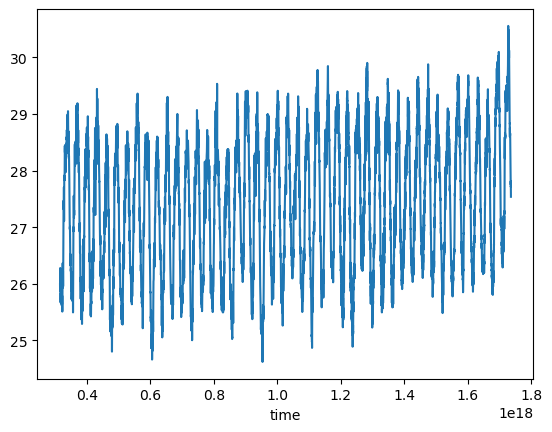

In [20]:
npr_ts.plot()

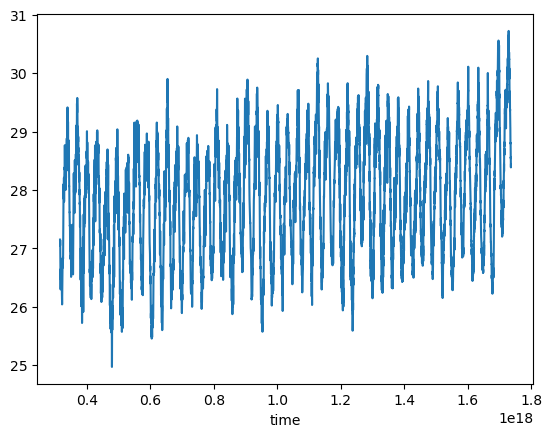

In [21]:
spr_ts.plot()

In [22]:
import pandas as pd

In [23]:
time = pd.date_range(start="1995-01-01", end="2024-12-31",freq="D")

In [24]:
time[390:440]

DatetimeIndex(['1996-01-26', '1996-01-27', '1996-01-28', '1996-01-29',
               '1996-01-30', '1996-01-31', '1996-02-01', '1996-02-02',
               '1996-02-03', '1996-02-04', '1996-02-05', '1996-02-06',
               '1996-02-07', '1996-02-08', '1996-02-09', '1996-02-10',
               '1996-02-11', '1996-02-12', '1996-02-13', '1996-02-14',
               '1996-02-15', '1996-02-16', '1996-02-17', '1996-02-18',
               '1996-02-19', '1996-02-20', '1996-02-21', '1996-02-22',
               '1996-02-23', '1996-02-24', '1996-02-25', '1996-02-26',
               '1996-02-27', '1996-02-28', '1996-02-29', '1996-03-01',
               '1996-03-02', '1996-03-03', '1996-03-04', '1996-03-05',
               '1996-03-06', '1996-03-07', '1996-03-08', '1996-03-09',
               '1996-03-10', '1996-03-11', '1996-03-12', '1996-03-13',
               '1996-03-14', '1996-03-15'],
              dtype='datetime64[ns]', freq='D')

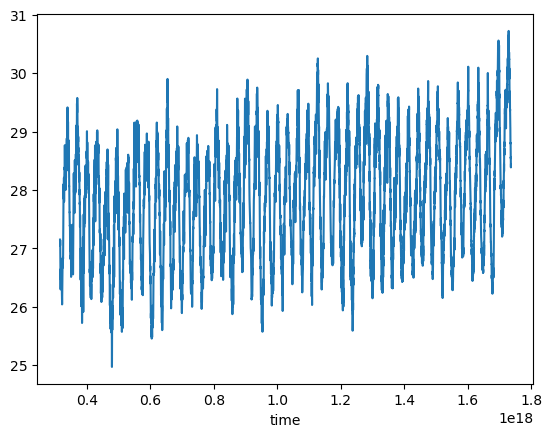

In [25]:
spr_ts.plot()

### Write these daily SST timeseries out

In [26]:
ds_out = xr.Dataset()

path = '/glade/derecho/scratch/kristenk/bleaching_work'

ds_out['SPR_sst'] = spr_ts
ds_out['NPR_sst'] = npr_ts

ds_out.to_netcdf(path + '/PR_SST_timeseries_daily.nc',mode='w')